In [10]:
import matplotlib.dates as mdates
import numpy as np
np.set_printoptions(threshold=3)
np.set_printoptions(suppress=True)

from numpy import genfromtxt
import matplotlib.pyplot as plt
from scipy.stats import norm
from sympy import Symbol, symbols, Matrix, sin, cos
from sympy import init_printing
# from sympy import init_session
# from sympy.utilities.codegen import codegen

In [11]:
init_printing(use_latex=True)

x0 = []
x1 = []
x2 = []
pAcum = []

In [12]:
def prediction(X_hat_t_1,P_t_1,Q_t,drivingStraight):
    X_hat_t=X_hat_t_1

    if drivingStraight: # Driving straight
        X_hat_t[0] = X_hat_t_1[0] + X_hat_t_1[3]*dt * np.cos(X_hat_t_1[2])
        X_hat_t[1] = X_hat_t_1[1] + X_hat_t_1[3]*dt * np.sin(X_hat_t_1[2])
        X_hat_t[2] = X_hat_t_1[2]
        X_hat_t[3] = X_hat_t_1[3] + X_hat_t_1[5]*dt
        X_hat_t[4] = 0.0000001 # avoid numerical issues in Jacobians
        X_hat_t[5] = X_hat_t_1[5]
       
    else: # otherwise
        X_hat_t[0] = X_hat_t_1[0] + (X_hat_t_1[3]/X_hat_t_1[4]) * (np.sin(X_hat_t_1[4]*dt+X_hat_t_1[2]) - np.sin(X_hat_t_1[2]))
        X_hat_t[1] = X_hat_t_1[1] + (X_hat_t_1[3]/X_hat_t_1[4]) * (-np.cos(X_hat_t_1[4]*dt+X_hat_t_1[2])+ np.cos(X_hat_t_1[2]))
        X_hat_t[2] = (X_hat_t_1[2] + X_hat_t_1[4]*dt + np.pi) % (2.0*np.pi) - np.pi
        X_hat_t[3] = X_hat_t_1[3] + X_hat_t_1[5]*dt
        X_hat_t[4] = X_hat_t_1[4] # Constant Turn Rate
        X_hat_t[5] = X_hat_t_1[5] # Constant Acceleration
        
    
    # Calculate the Jacobian of the Dynamic Matrix A
    # see "Calculate the Jacobian of the Dynamic Matrix with respect to the state vector"
    a13 = float((X_hat_t[3]/X_hat_t[4]) * (np.cos(X_hat_t[4]*dt+X_hat_t[2]) - np.cos(X_hat_t[2])))
    a14 = float((1.0/X_hat_t[4]) * (np.sin(X_hat_t[4]*dt+X_hat_t[2]) - np.sin(X_hat_t[2])))
    a15 = float((dt*X_hat_t[3]/X_hat_t[4])*np.cos(X_hat_t[4]*dt+X_hat_t[2]) - (X_hat_t[3]/X_hat_t[4]**2)*(np.sin(X_hat_t[4]*dt+X_hat_t[2]) - np.sin(X_hat_t[2])))
    a23 = float((X_hat_t[3]/X_hat_t[4]) * (np.sin(X_hat_t[4]*dt+X_hat_t[2]) - np.sin(X_hat_t[2])))
    a24 = float((1.0/X_hat_t[4]) * (-np.cos(X_hat_t[4]*dt+X_hat_t[2]) + np.cos(X_hat_t[2])))
    a25 = float((dt*X_hat_t[3]/X_hat_t[4])*np.sin(X_hat_t[4]*dt+X_hat_t[2]) - (X_hat_t[3]/X_hat_t[4]**2)*(-np.cos(X_hat_t[4]*dt+X_hat_t[2]) + np.cos(X_hat_t[2])))
    JA = np.matrix([[1.0, 0.0, a13, a14, a15, 0.0],
                    [0.0, 1.0, a23, a24, a25, 0.0],
                    [0.0, 0.0, 1.0, 0.0, dt, 0.0],
                    [0.0, 0.0, 0.0, 1.0, 0.0, dt],
                    [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
                    [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])
    
    
    # Project the error covariance ahead
    P_t_1 = JA*P_t_1*JA.T + Q_t
    return X_hat_t,P_t_1

def update(X_hat_t,P_t,Z_t,R_t,GPSAvailable):
    hx = np.matrix([[float(X_hat_t[0])],
                    [float(X_hat_t[1])],
                    [float(X_hat_t[3])],
                    [float(X_hat_t[4])],
                    [float(X_hat_t[5])]])

    if GPSAvailable: # with 10Hz, every 5th step
        JH = np.matrix([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                        [0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
                        [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])
    else: # every other step
        JH = np.matrix([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
                        [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])        
    
    S = JH*P_t*JH.T + R_t
    K = (P_t*JH.T) * np.linalg.inv(S)
    #print("K:\n",K)
    # Update the estimate via
    Z = Z_t.reshape(JH.shape[0],1)
    #print("Z:\n",Z)
    y = Z - (hx)                         # Innovation or Residual
    X_t = X_hat_t + (K*y)

    # Update the error covariance
    
    
    I = np.eye(X_hat_t.shape[0])
    P_t = (I - (K*JH))*P_t


    x0.append(float(X_t[0]))
    x1.append(float(X_t[1]))
    x2.append(float(X_t[2]))
    return X_t,P_t

In [13]:
numstates = 6 # States

dt = 1.0/50.0 # Sample Rate of the Measurements is 50Hz
dtGPS=1.0/10.0 # Sample Rate of GPS is 10Hz

In [14]:
Xest, vs, psis, dpsis, dts, xs, ys, lats, lons, axs = symbols('\hat{X} v \psi \dot\psi T x y lat lon a')

gs = Matrix([[xs+(vs/dpsis)*(sin(psis+dpsis*dts)-sin(psis))],
             [ys+(vs/dpsis)*(-cos(psis+dpsis*dts)+cos(psis))],
             [psis+dpsis*dts],
             [axs*dts + vs],
             [dpsis],
             [axs]])
state = Matrix([xs,ys,psis,vs,dpsis,axs])
#Measurment Matrix
hs = Matrix([[xs],
             [ys],
             [vs],
             [dpsis],
             [axs]])

In [15]:
#Initial State cov
P_t = np.diag([1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0])

#Measurment cov

varGPS = 5.0 # Standard Deviation of GPS Measurement
varspeed = 3.0 # Variance of the speed measurement
varyaw = 0.1 # Variance of the yawrate measurement
varacc = 1.0 # Variance of the longitudinal Acceleration
R_t = np.diag([varGPS**2, varGPS**2, varspeed**2, varyaw**2, varacc**2])

#Process cov
sGPS     = 0.5*8.8*dt**2  # assume 8.8m/s2 as maximum acceleration, forcing the vehicle
sCourse  = 0.1*dt # assume 0.1rad/s as maximum turn rate for the vehicle
sVelocity= 8.8*dt # assume 8.8m/s2 as maximum acceleration, forcing the vehicle
sYaw     = 1.0*dt # assume 1.0rad/s2 as the maximum turn rate acceleration for the vehicle
sAccel   = 0.5

Q_t = np.diag([sGPS**2, sGPS**2, sCourse**2, sVelocity**2, sYaw**2, sAccel**2])

In [16]:
path="data/"
datafile = '2014-03-26-000-Data.csv'

fullPath=path+datafile

def bytespdate2num(fmt, encoding='utf-8'):
    strconverter = mdates.date2num(fmt)
    def bytesconverter(b):
        s = b.decode(encoding)
        return strconverter(s)
    return bytesconverter

date, time, millis, ax, ay, az, rollrate, pitchrate, yawrate, \
roll, pitch, yaw, speed, course, latitude, longitude, altitude, \
pdop, hdop, vdop, epe, fix, satellites_view, satellites_used, temp \
    = np.loadtxt(fullPath, delimiter=',', unpack=True, 
                #   converters={1:bytespdate2num('%H%M%S%f'),
                #               0: bytespdate2num('%y%m%d')},
                  skiprows=1)


# A course of 0 means the Car is traveling north bound
# and 90 means it is traveling east bound.
# In the Calculation following, East is Zero and North is 90
# We need an offset.
course =(-course+90.0)

# ## Approx. Lat/Lon to Meters to check Location
RadiusEarth = 6378388.0 # m
arc= 2.0*np.pi*(RadiusEarth+altitude)/360.0 # m/

dx = arc * np.cos(latitude*np.pi/180.0) * np.hstack((0.0, np.diff(longitude))) # in m
dy = arc * np.hstack((0.0, np.diff(latitude))) # in m

mx = np.cumsum(dx)
my = np.cumsum(dy)

ds = np.sqrt(dx**2+dy**2)

GPS=(ds!=0.0).astype('bool') # GPS Trigger for Kalman Filter

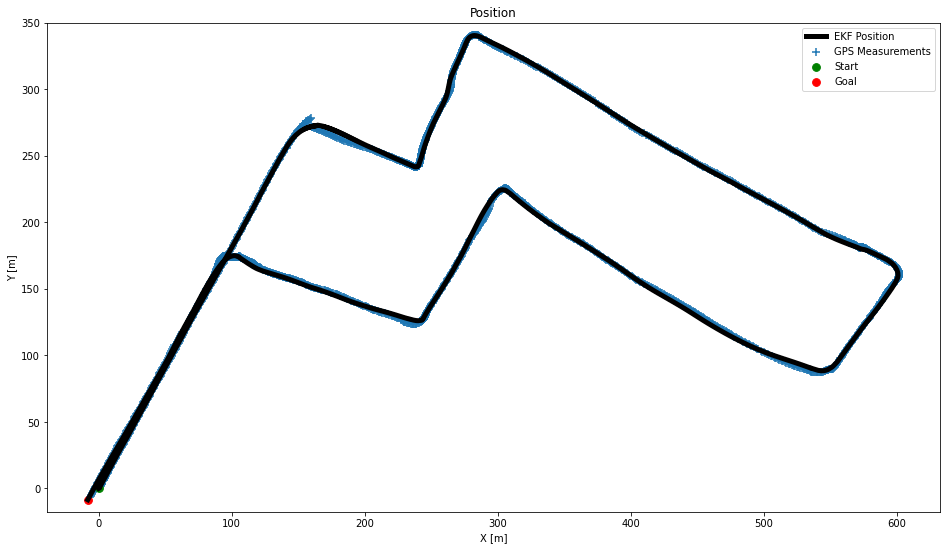

In [17]:
# ## Initial State
X_hat_t = np.matrix([[mx[0], my[0], course[0]/180.0*np.pi, speed[0]/3.6+0.001, yawrate[0]/180.0*np.pi, ax[0]]]).T

measurements = np.vstack((mx, my, speed/3.6, yawrate/180.0*np.pi, ax))
# Lenth of the measurement
m = measurements.shape[1]

for i in range(measurements.shape[1]):
#for i in range(3):
    if  np.abs(yawrate[i])<0.0001:
        drivingStraight=True
    else:
        drivingStraight=False
    
    
    X_hat_t,P_hat_t = prediction(X_hat_t,P_t,Q_t,drivingStraight)
    #print("Prediction:")
    #print("X_hat_t:\n",X_hat_t,"\nP_t:\n",P_hat_t)
   
    Z_t=measurements[:,i]
    if GPS[i]:
        GPSAvailable=True
    else:
        GPSAvailable=False
    
    X_t,P_t=update(X_hat_t,P_hat_t,Z_t,R_t,GPSAvailable)
    #print("Update:")
    #print("X_t:\n",X_t,"\nP_t:\n",P_t)
    X_hat_t=X_t
    P_hat_t=P_t

    pAcum.append(np.trace(P_hat_t))
    
fig = plt.figure(figsize=(16,9))

# EKF State
plt.quiver(x0,x1,np.cos(x2), np.sin(x2), color='#94C600', units='xy', width=0.05, scale=0.5)
plt.plot(x0,x1, label='EKF Position', c='k', lw=5)

# Measurements
plt.scatter(mx[::5],my[::5], s=50, label='GPS Measurements', marker='+')

# Start/Goal
plt.scatter(x0[0],x1[0], s=60, label='Start', c='g')
plt.scatter(x0[-1],x1[-1], s=60, label='Goal', c='r')

plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.title('Position')
plt.legend(loc='best')
plt.axis('equal')
plt.show()

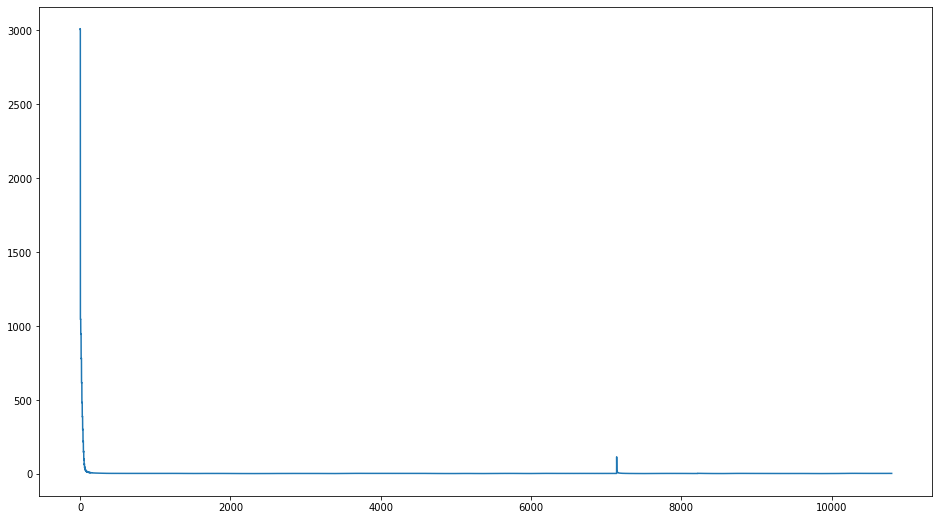

In [18]:
fig = plt.figure(figsize=(16,9))
# print(pAcum)
plt.plot(pAcum)